In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
# import pymongo
# import itertools
# from concurrent.futures import ProcessPoolExecutor
# from sklearn import preprocessing
# from sklearn.preprocessing import MinMaxScaler
# from sklearn import neighbors
# from sklearn.externals import joblib
from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

In [2]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

# for symbol in NASDAQ100:
for symbol in ['NDX']:
#     if symbol == 'WDAY':
#         ignore = False
#     if ignore:
#         continue
    datafile = spider.get_stock_data(symbol, timeframe)
    print(datafile)

../database/market/NDX.csv
Wall time: 8.22 s


In [3]:
%%time

# symbol = 'TSLA'

stock_df_dict = {}

for symbol in NASDAQ100:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close', 'volume']]
    stock_df = stock_df.loc[:, ['date', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 处理Coinmarketcap的早期缺失数据
    if symbol in CRYPTOCURRENCY:
        stock_df = stock_df.replace(to_replace='-', value=pd.np.nan)

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期，和news_df['publish_time']一致
    stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    stock_df.set_index(['date'], inplace=True)
    stock_df = stock_df.sort_index(axis=0, ascending=True)

    stock_df['pct_change'] = stock_df.close.pct_change(1)
    
#     stock_df = stock_df['2016-01-01':]
    
    stock_df_dict[symbol] = stock_df

# stock_df
# df = stock_df.copy()

Wall time: 4min 19s


In [6]:
%%time

### BT

PROPERTY = 100000
CASH = 100000
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

start_date = '2008-06-02'
# start_date = '2017-01-03'
end_date = '2018-05-01'

yesterday = None

show_df = None
show_df = stock_df_dict['NDX'].copy()
show_df['CASH'] = pd.np.nan
show_df['PROPERTY'] = pd.np.nan

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    for order in hold:
        
        is_sell_expect_rise = stock_df_dict[order[1]].loc[today, 'close'] > order[4]
        
        if is_sell_expect_rise:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s win SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif stock_df_dict[order[1]].loc[today, 'close'] / order[4] < 0.75:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s loss SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'LOSS',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif today - order[0] > 30:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s TIMEUP SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'TIMEUP',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in NASDAQ100:
        if today not in stock_df_dict[symbol].index:
            continue
        
        # buy drop wait rise back
        is_buy = (stock_df_dict[symbol].loc[today, 'pct_change'] < -0.05)
        
        # turtle buy N days
#         N = 20
#         is_buy = (stock_df_dict[symbol].loc[today, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).min()).loc[today])
        
        if is_buy:
            if stock_df_dict[symbol].loc[yesterday, 'close'] < stock_df_dict[symbol].shift(7).loc[yesterday, 'close']:
                continue
            if CASH < 10000:
                continue
            buy = int(CASH / 10 / stock_df_dict[symbol].loc[today, 'close'])
#             buy = int(PROPERTY / 2 / stock_df_dict[symbol].loc[today, 'close'])
            CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
            hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']])
#             print('%s 进场 BUY  %s * %d @ %f EXPECT %f' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'BUY',
                    'reason': 'ENTER',
                    'symbol': symbol,
                    'count': buy,
                    'price': stock_df_dict[symbol].loc[today, 'close'],
                    'buy_price': stock_df_dict[symbol].loc[today, 'close'],
                    'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
            

print(CASH)
print(hold)
print(PROPERTY)

# s = 0
# c = 0
# for symbol in NASDAQ100:
# # for symbol in ['TSLA', 'NVDA', 'BIDU', 'FB']:
#     s_p = stock_df_dict[symbol].loc['2017-01-03', 'close']
#     e_p = stock_df_dict[symbol].loc['2018-01-03', 'close']
#     print(symbol, s_p, e_p, e_p / s_p)
#     s += e_p / s_p
#     c += 1

# print(s / c)

s_p = stock_df_dict['NDX'].loc[start_date, 'close']
e_p = stock_df_dict['NDX'].loc[end_date, 'close']
print('NDX', s_p, e_p, e_p / s_p)


89019.6853
[[Period('2018-04-18', 'D'), 'AMAT', 492, 54.729999999999997, 57.859999999999999], [Period('2018-04-19', 'D'), 'ALGN', 106, 252.78, 277.05000000000001], [Period('2018-04-19', 'D'), 'AMAT', 472, 51.189999999999998, 54.729999999999997], [Period('2018-04-19', 'D'), 'ASML', 111, 195.09999999999999, 206.31999999999999], [Period('2018-04-19', 'D'), 'KLAC', 191, 102.29000000000001, 108.23999999999999], [Period('2018-04-19', 'D'), 'LRCX', 92, 190.38999999999999, 203.77000000000001], [Period('2018-04-19', 'D'), 'SWKS', 169, 93.879999999999995, 98.959999999999994], [Period('2018-04-24', 'D'), 'PCAR', 286, 64.920000000000002, 69.409999999999997], [Period('2018-04-24', 'D'), 'QRTEA', 707, 23.640000000000001, 25.219999999999999], [Period('2018-04-25', 'D'), 'CHKP', 156, 96.329999999999998, 102.91], [Period('2018-04-26', 'D'), 'EBAY', 350, 38.68, 40.969999999999999], [Period('2018-04-27', 'D'), 'LBTYA', 400, 30.510000000000002, 32.490000000000002], [Period('2018-04-27', 'D'), 'LBTYK', 376

In [7]:
%%time
# %%lprun

### Turtle

PROPERTY = 100000
CASH = 100000
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

start_date = '2008-06-02'
# start_date = '2017-01-03'
end_date = '2018-05-01'

yesterday = None

# show_df = None
# show_df = stock_df_dict['NDX'].copy()
show_df['CASH_T'] = pd.np.nan
show_df['PROPERTY_T'] = pd.np.nan

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    for order in hold:
        
#         is_sell_expect_rise = stock_df_dict[order[1]].loc[today, 'close'] > order[4]
        N = 15
        is_sell = (stock_df_dict[order[1]].loc[today, 'close'] == (stock_df_dict[order[1]].loc[:, 'close'].rolling(N).min()).loc[today])
        
        if is_sell_expect_rise:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s win SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

#         elif stock_df_dict[order[1]].loc[today, 'close'] / order[4] < 0.75:
#             hold.remove(order)
#             CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
# #             print('%s loss SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
#             recode_df = recode_df.append(
#                 {
#                     'date': today,
#                     'ops': 'SELL',
#                     'reason': 'LOSS',
#                     'symbol': order[1],
#                     'count': order[2],
#                     'price': stock_df_dict[order[1]].loc[today, 'close'],
#                     'buy_price': order[3],
#                     'expect': order[4],
#                     'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
#                     'cash': CASH,
#                     'property': PROPERTY,
#                 },
#                 ignore_index=True
#             )

#         elif today - order[0] > 30:
#             hold.remove(order)
#             CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
# #             print('%s TIMEUP SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
#             recode_df = recode_df.append(
#                 {
#                     'date': today,
#                     'ops': 'SELL',
#                     'reason': 'TIMEUP',
#                     'symbol': order[1],
#                     'count': order[2],
#                     'price': stock_df_dict[order[1]].loc[today, 'close'],
#                     'buy_price': order[3],
#                     'expect': order[4],
#                     'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
#                     'cash': CASH,
#                     'property': PROPERTY,
#                 },
#                 ignore_index=True
#             )
    
    for symbol in NASDAQ100:
        if today not in stock_df_dict[symbol].index:
            continue
        
        # buy drop wait rise back
#         is_buy = (stock_df_dict[symbol].loc[today, 'pct_change'] < -0.05)
        
        # turtle buy N days
        N = 30
        is_buy = (stock_df_dict[symbol].loc[today, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[today])
        
        if is_buy:
#             if stock_df_dict[symbol].loc[yesterday, 'close'] < stock_df_dict[symbol].shift(7).loc[yesterday, 'close']:
#                 continue
            if CASH < 10000:
                continue
            buy = int(CASH / 10 / stock_df_dict[symbol].loc[today, 'close'])
#             buy = int(PROPERTY / 2 / stock_df_dict[symbol].loc[today, 'close'])
            CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
            hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']])
#             print('%s 进场 BUY  %s * %d @ %f EXPECT %f' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'BUY',
                    'reason': 'ENTER',
                    'symbol': symbol,
                    'count': buy,
                    'price': stock_df_dict[symbol].loc[today, 'close'],
                    'buy_price': stock_df_dict[symbol].loc[today, 'close'],
                    'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    yesterday = today
            

print(CASH)
print(hold)
print(PROPERTY)

# s = 0
# c = 0
# for symbol in NASDAQ100:
# # for symbol in ['TSLA', 'NVDA', 'BIDU', 'FB']:
#     s_p = stock_df_dict[symbol].loc['2017-01-03', 'close']
#     e_p = stock_df_dict[symbol].loc['2018-01-03', 'close']
#     print(symbol, s_p, e_p, e_p / s_p)
#     s += e_p / s_p
#     c += 1

# print(s / c)

s_p = stock_df_dict['NDX'].loc[start_date, 'close']
e_p = stock_df_dict['NDX'].loc[end_date, 'close']
print('NDX', s_p, e_p, e_p / s_p)


9994.975
[[Period('2008-06-30', 'D'), 'AMGN', 212, 47.159999999999997, 46.369999999999997], [Period('2008-06-30', 'D'), 'CELG', 281, 31.934999999999999, 31.664999999999999], [Period('2008-06-30', 'D'), 'ILMN', 186, 43.555, 43.395000000000003], [Period('2008-07-01', 'D'), 'ALXN', 391, 18.640000000000001, 18.125], [Period('2008-07-01', 'D'), 'AMGN', 134, 48.640000000000001, 47.159999999999997], [Period('2008-07-01', 'D'), 'CELG', 170, 34.630000000000003, 31.934999999999999], [Period('2008-07-01', 'D'), 'ILMN', 120, 44.274999999999999, 43.555], [Period('2008-07-01', 'D'), 'VRTX', 139, 34.310000000000002, 33.469999999999999], [Period('2008-07-02', 'D'), 'AMGN', 88, 48.840000000000003, 48.640000000000001], [Period('2008-07-02', 'D'), 'ILMN', 86, 45.049999999999997, 44.274999999999999], [Period('2008-07-03', 'D'), 'AMGN', 68, 50.840000000000003, 48.840000000000003], [Period('2008-07-08', 'D'), 'ALXN', 165, 19.055, 18.329999999999998], [Period('2008-07-08', 'D'), 'CELG', 79, 35.90999999999999

In [ ]:
for symbol, stock_df in stock_df_dict.items():
    df = stock_df.loc[start_date:end_date, 'close']
#     print(df)
    s_p = df.head(1).values
    e_p = df.tail(1).values
    print(symbol, s_p, e_p, e_p / s_p)


In [ ]:
# pd.set_option('display.max_rows', 1000)
# recode_df
# recode_df.loc[recode_df['ops']=='SELL']

d:\python3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
d:\python3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
d:\python3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

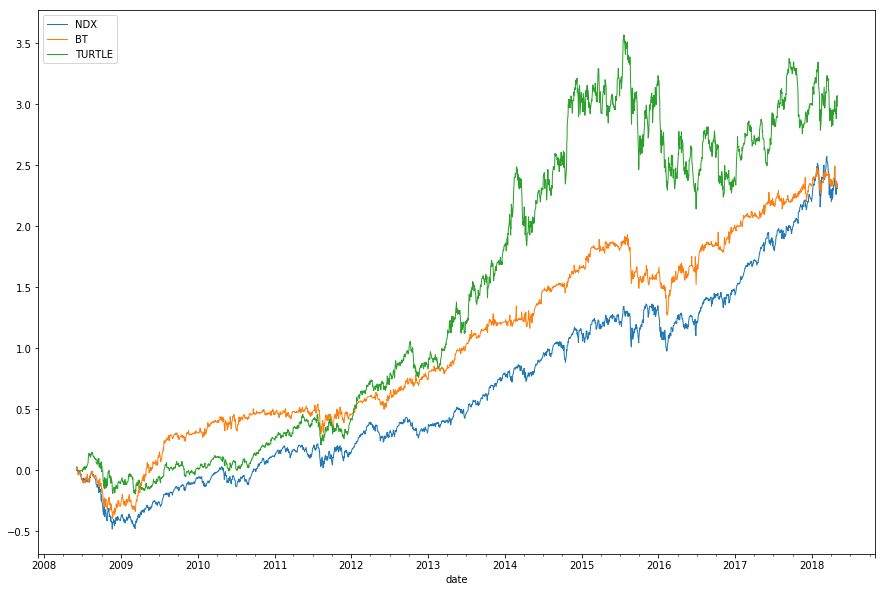

In [8]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False)
df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
df['PROPERTY'] = (df['PROPERTY'] - df.head(1)['PROPERTY'].values) / df.head(1)['PROPERTY'].values
df['PROPERTY_T'] = (df['PROPERTY_T'] - df.head(1)['PROPERTY_T'].values) / df.head(1)['PROPERTY_T'].values
# df['CASH'] = df['CASH'] / df.head(1)['CASH'].values
# stock_df_dict['NDX']

ax = df.plot(kind='line', y='close', label='NDX', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY', secondary_y=False, label='BT', linewidth=1, ax=ax)
ax = df.plot(kind='line', y='PROPERTY_T', secondary_y=False, label='TURTLE', linewidth=1, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()